In [1]:
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import lax

from jax import make_jaxpr
from jax import random
from jax import device_put
import matplotlib.pyplot as plt

## Similar to NumPy

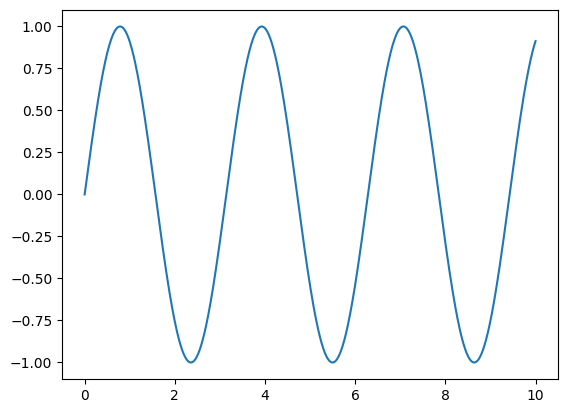

In [2]:
x_np = np.linspace(0, 10, 1000)
y_np = 2 * np.sin(x_np) * np.cos(x_np)
plt.plot(x_np, y_np);

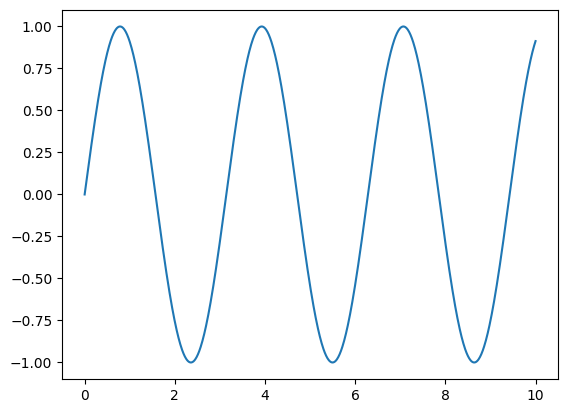

In [3]:
x_jnp = jnp.linspace(0, 10, 1000)
y_jnp = 2 * jnp.sin(x_np) * jnp.cos(x_np)
plt.plot(x_jnp, y_jnp);

## Immutable arrays as FP


In [4]:
size = 30
index = 0
value = 23

In [5]:
x = np.arange(size)
print(x)
x[index] = value
print(x)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[23  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


In [6]:
x = jnp.arange(size)
print(x)
x[index] = value
print(x)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]


TypeError: '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [7]:
y = x.at[index].set(value)
x, y

(Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32),
 Array([23,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32))

## Random numbers handled differently

In [8]:
seed = 0
key = random.PRNGKey(seed)

x = random.normal(key, (10,))
type(x), x

(jaxlib.xla_extension.ArrayImpl,
 Array([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 , -0.44030377,
        -0.1521442 , -0.67135346, -0.5908641 ,  0.73168886,  0.5673026 ],      dtype=float32))

## Transform functions

In [9]:
def visualise_fn(fn, l=-10, r=10, n=1000):
    x = np.linspace(l, r, num=n)
    y = fn(x)
    plt.plot(x, y)

In [10]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

In [11]:
sel_jit = jit(selu)

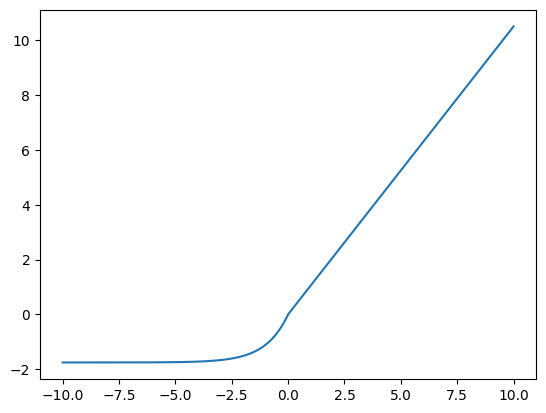

In [12]:
visualise_fn(selu)

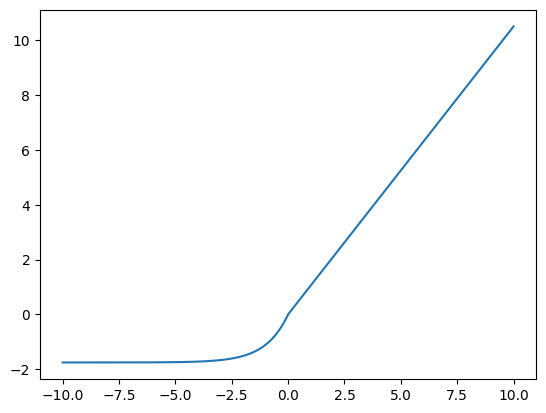

In [13]:
visualise_fn(sel_jit)

## Gradients

In [14]:
def sum_logistic(x):
    return jnp.sum(1. / (1. * jnp.exp(-x)))

In [15]:
x = jnp.arange(3.)

In [16]:
loss = sum_logistic

In [17]:
grad_loss = grad(loss)

In [18]:
loss(x), grad_loss(x)

(Array(11.107338, dtype=float32),
 Array([1.       , 2.7182815, 7.3890557], dtype=float32))

In [19]:
def sum_squared(x):
    return jnp.sum(x ** 2)

In [20]:
grad_loss = grad(sum_squared)
x, sum_squared(x), grad_loss(x)

(Array([0., 1., 2.], dtype=float32),
 Array(5., dtype=float32),
 Array([0., 2., 4.], dtype=float32))

In [21]:
jnp.eye(3)

Array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

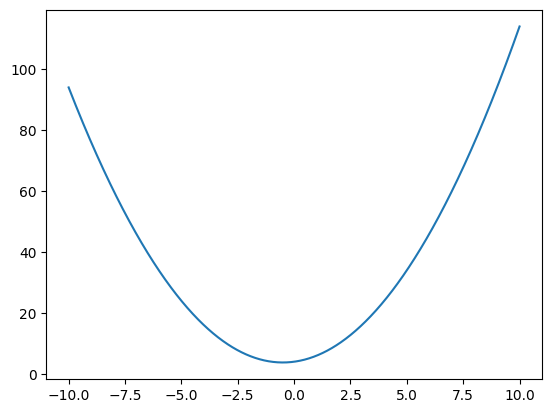

In [22]:
f = lambda x: x**2 + x + 4
visualise_fn(f)

In [23]:
y_ = grad(f)
y__ = grad(y_)
y___ = grad(y__)

In [24]:
y_(1.), y__(1.), y___(1.)

(Array(3., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True))

In [25]:
f = lambda x, y: x**2 + x + 4 + y**2

In [26]:
y_ = grad(f)
y__ = grad(y_)
y___ = grad(y__)

In [27]:
y_(1., 2.), y__(1., 2.), y___(1., 2.)

(Array(3., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True))

In [28]:
y_ = grad(f, argnums=(1))
y__ = grad(y_, argnums=(1))
y___ = grad(y__, argnums=(1))

In [29]:
y_(1., 2.), y__(1., 2.), y___(1., 2.)

(Array(4., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True),
 Array(0., dtype=float32, weak_type=True))

## Jacobian and Hessian

In [30]:
from jax import jacfwd, jacrev

f = lambda x, y: x**2 + y**2

In [31]:
# jacobian
jacrev(f, argnums=(0, 1))(1., 1.)

(Array(2., dtype=float32, weak_type=True),
 Array(2., dtype=float32, weak_type=True))

In [32]:
# hessian
def hessian(f):
    return jit(jacfwd(jacrev(f, argnums=(0, 1)), argnums=(0, 1)))

In [33]:
hessian(f)(1., 1.)

((Array(2., dtype=float32, weak_type=True),
  Array(0., dtype=float32, weak_type=True)),
 (Array(0., dtype=float32, weak_type=True),
  Array(2., dtype=float32, weak_type=True)))

## vmap

Write for a single apply, broadcast it to the entire batch using vmap

In [34]:
# vmap
W = random.normal(key, (150, 100))
batched_x = random.normal(key, (10, 100))

In [35]:
W.shape, batched_x.shape

((150, 100), (10, 100))

In [36]:
def apply_matrix(W, x):
    return jnp.dot(W, x)

In [37]:
def naive_way(W, batched_x):
    return jnp.stack([apply_matrix(W, x) for x in batched_x])

In [38]:
naive_way(W, batched_x).shape

(10, 150)

In [39]:
@jit
def batched_apply(W, batched_x):
    return jnp.dot(batched_x, W.T)

In [40]:
batched_apply(W, batched_x).shape

(10, 150)

In [41]:
@jit
def vmapped(W, batched_x):
    return vmap(apply_matrix, in_axes=(None, 0))(W, batched_x)

vmapped(W, batched_x).shape

(10, 150)

## Gotchas

In [42]:
# shape should not change in between while JITting
def get_negatives(x):
    return x[x < 0]

x = random.normal(key, (10,))

In [43]:
x, get_negatives(x)

(Array([-0.3721109 ,  0.26423115, -0.18252768, -0.7368197 , -0.44030377,
        -0.1521442 , -0.67135346, -0.5908641 ,  0.73168886,  0.5673026 ],      dtype=float32),
 Array([-0.3721109 , -0.18252768, -0.7368197 , -0.44030377, -0.1521442 ,
        -0.67135346, -0.5908641 ], dtype=float32))

In [44]:
jit(get_negatives)(x)

NonConcreteBooleanIndexError: Array boolean indices must be concrete; got ShapedArray(bool[10])

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.NonConcreteBooleanIndexError

In [45]:
# jax runs the first call only with the shapes and not the values
# in the second call it runs with the actual values + ignores all the
# side effect functions (for instance print here returns a value - FP)
@jit
def f(x, y):
    print("Running f")
    print(f"{x} - {type(x)}")
    print(f"{y} - {type(y)}")
    return jnp.dot(x + 1, y + 1)

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x = np.random.randn(3, 4)
y = np.random.randn(4)
print(f(x, y))

x = np.random.randn(3, 5)
y = np.random.randn(5)
print(f(x, y))

Running f
Traced<ShapedArray(float32[3,4])>with<DynamicJaxprTrace(level=1/0)> - <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
Traced<ShapedArray(float32[4])>with<DynamicJaxprTrace(level=1/0)> - <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
[ 3.5284467  10.210641    0.53476125]
[2.433679  4.8851185 3.6018305]
Running f
Traced<ShapedArray(float32[3,5])>with<DynamicJaxprTrace(level=1/0)> - <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
Traced<ShapedArray(float32[5])>with<DynamicJaxprTrace(level=1/0)> - <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>
[0.73125184 2.295424   4.837416  ]


In [46]:
def f(x, y):
    return jnp.dot(x + 1, y + 1)

In [47]:
print(make_jaxpr(f)(x, y))

{ lambda ; a:f32[3,5] b:f32[5]. let
    c:f32[3,5] = add a 1.0
    d:f32[5] = add b 1.0
    e:f32[3] = dot_general[
      dimension_numbers=(([1], [0]), ([], []))
      preferred_element_type=float32
    ] c d
  in (e,) }


In [48]:
# again, for the first call while JITting, the values themselves
# are not passed down, but only the input and output shape for caching
# or compiling purposes
@jit
def f(x, neg):
    return -x if neg else x

f(1, True)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at /var/folders/v1/w_dx9xn11zlgpffrd5ptcb380000gn/T/ipykernel_56756/2906781559.py:4 for jit. This concrete value was not available in Python because it depends on the value of the argument neg.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [49]:
# hack for the above error, use static args and let jax know
# that it should pass down this arg as its value
from functools import partial

@partial(jit, static_argnums=(1,))
def f(x, neg):
    print(x)
    return -x if neg else x

f(1, True)
f(2, False)
# make_jaxpr(f)(1, True)

Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>
Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>


Array(2, dtype=int32, weak_type=True)

In [50]:
@jit
def f(x):
    print(x)
    print(x.shape)
    print(jnp.array(x.shape).prod())
    return x.reshape(jnp.array(x.shape).prod())

In [51]:
# can't do operation on non traced objects and traced objects
f(jnp.ones((2, 3)))

Traced<ShapedArray(float32[2,3])>with<DynamicJaxprTrace(level=1/0)>
(2, 3)
Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>


TypeError: Shapes must be 1D sequences of concrete values of integer type, got [Traced<ShapedArray(int32[])>with<DynamicJaxprTrace(level=1/0)>].
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function f at /var/folders/v1/w_dx9xn11zlgpffrd5ptcb380000gn/T/ipykernel_56756/3655646564.py:1 for jit. This value became a tracer due to JAX operations on these lines:

  operation a[35m:i32[2][39m = convert_element_type[new_dtype=int32 weak_type=False] b
    from line /var/folders/v1/w_dx9xn11zlgpffrd5ptcb380000gn/T/ipykernel_56756/3655646564.py:6:21 (f)

In [52]:
# hack for the above error, use numpy functions
@jit
def f(x):
    print(x)
    print(x.shape)
    print(np.prod(x.shape))
    return x.reshape((np.prod(x.shape),))

In [53]:
f(x)

Traced<ShapedArray(float32[3,5])>with<DynamicJaxprTrace(level=1/0)>
(3, 5)
15


Array([-0.78862184,  1.0279201 , -0.24493742, -0.63556296, -0.9919703 ,
        0.03216176,  1.6890628 ,  0.5982644 , -0.6006153 , -0.31668836,
        0.4656034 , -0.05838453,  1.3169982 ,  0.5757224 ,  1.4883255 ],      dtype=float32)

always use pure functions - FP paradigm
1. all input is passed through the args and output is returned through the return statement, don't modify state outside
2. a pure function will always return the same result if invoked with the same inputs - no randomness

print statements make functions impure

In [54]:
# calls cached version and does not update the state outside the function
g = 0

def impure(x):
    return x + g

print(jit(impure)(1))

g = 10

print(jit(impure)(1))

1
1


In [55]:
def pure_uses_internal_state(x):
    state = {"even": 0, "odd": 0}
    for i in range(10):
        state["even" if i % 2 == 0 else "odd"] += x
    return state["even"] + state["odd"]

print(jit(pure_uses_internal_state)(5))

50


In [56]:
from jax import lax

In [57]:
array = jnp.arange(10)
print(lax.fori_loop(0, 10, lambda i, x: x+array[i], 0))

45


In [58]:
# iterators don't work
iterator = iter(range(10))
print(lax.fori_loop(0, 10, lambda i, x: x+next(iterator), 0))

0


In [59]:
# inplace does not happen but XLA is smart enough to make this efficient
jax_array = jnp.zeros((3, 3))
updated_array = jax_array.at[1, :].set(1)

jax_array, updated_array

(Array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32),
 Array([[0., 0., 0.],
        [1., 1., 1.],
        [0., 0., 0.]], dtype=float32))

In [60]:
# out-of-bounds indexing errors do not exist

jnp.arange(10).at[11].add(23)

Array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [61]:
jnp.arange(10)[11]

Array(9, dtype=int32)

In [62]:
# python lists don't work

jnp.sum([1, 2, 3])

TypeError: sum requires ndarray or scalar arguments, got <class 'list'> at position 0.

In [63]:
make_jaxpr(jnp.sum)(jnp.array([1, 2, 3]))

{ lambda ; a:i32[3]. let b:i32[] = reduce_sum[axes=(0,)] a in (b,) }

In [64]:
def permissive_sum(x):
    return jnp.sum(jnp.array(x))

In [65]:
# not at all optimised
make_jaxpr(permissive_sum)([1, 2, 3])

{ lambda ; a:i32[] b:i32[] c:i32[]. let
    d:i32[] = convert_element_type[new_dtype=int32 weak_type=False] a
    e:i32[] = convert_element_type[new_dtype=int32 weak_type=False] b
    f:i32[] = convert_element_type[new_dtype=int32 weak_type=False] c
    g:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] d
    h:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] e
    i:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] f
    j:i32[3] = concatenate[dimension=0] g h i
    k:i32[] = reduce_sum[axes=(0,)] j
  in (k,) }

In [66]:
# dealing with random numbers
# state is passed as an argument and not decided internally
key = random.PRNGKey(seed)
print(key)

print(random.normal(key, shape=(1,)))
print(key)

print(random.normal(key, shape=(1,)))
print(key)

[0 0]
[-0.20584226]
[0 0]
[-0.20584226]
[0 0]


In [67]:
key, subkey = random.split(key)
normal_pseudorandom = random.normal(subkey, shape=(1,))
key, subkey, normal_pseudorandom

(Array([4146024105,  967050713], dtype=uint32),
 Array([2718843009, 1272950319], dtype=uint32),
 Array([-1.2515389], dtype=float32))

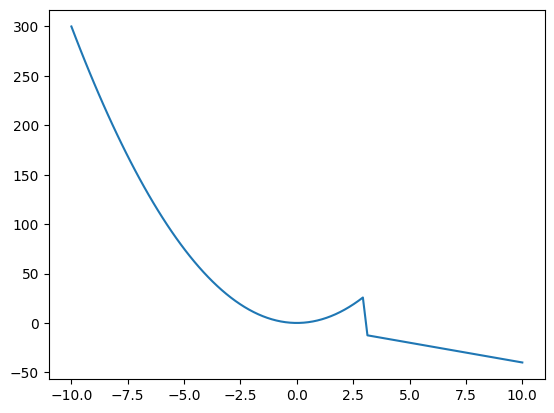

In [68]:
# control flow + grad() -> everything works well
def f(x):
    if x < 3:
        return 3. * x ** 2
    else:
        return -4 * x

x = np.linspace(-10, 10, 100)
y = [f(el) for el in x]
plt.plot(x, y);

In [69]:
grad(f)(2.), grad(f)(4.)

(Array(12., dtype=float32, weak_type=True),
 Array(-4., dtype=float32, weak_type=True))

In [70]:
# control flow + jit() -> problematic
jit(f)(1.)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function f at /var/folders/v1/w_dx9xn11zlgpffrd5ptcb380000gn/T/ipykernel_56756/2755955016.py:2 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [71]:
jit(f, static_argnums=(0,))(2)

Array(12., dtype=float32, weak_type=True)

In [72]:
f_jit = jit(f, static_argnums=(0,))

In [73]:
make_jaxpr(f_jit, static_argnums=(0,))(2)

{ lambda ; . let
    a:f32[] = pjit[name=f jaxpr={ lambda ; . let  in (12.0,) }] 
  in (a,) }

In [74]:
# loops
def f(x, n):
    y = 0.
    for i in range(n):
        y += x[i]
    return y

In [75]:
f_jit = jit(f, static_argnums=(1,))

In [76]:
x = (jnp.array([2, 3, 4]), 15)

In [77]:
make_jaxpr(f_jit, static_argnums=(1,))(*x)

{ lambda ; a:i32[3]. let
    b:f32[] = pjit[
      name=f
      jaxpr={ lambda ; c:i32[3]. let
          d:i32[1] = slice[limit_indices=(1,) start_indices=(0,) strides=None] c
          e:i32[] = squeeze[dimensions=(0,)] d
          f:f32[] = convert_element_type[new_dtype=float32 weak_type=True] e
          g:f32[] = add 0.0 f
          h:i32[1] = slice[limit_indices=(2,) start_indices=(1,) strides=None] c
          i:i32[] = squeeze[dimensions=(0,)] h
          j:f32[] = convert_element_type[new_dtype=float32 weak_type=True] i
          k:f32[] = add g j
          l:i32[1] = slice[limit_indices=(3,) start_indices=(2,) strides=None] c
          m:i32[] = squeeze[dimensions=(0,)] l
          n:f32[] = convert_element_type[new_dtype=float32 weak_type=True] m
          o:f32[] = add k n
          p:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] 3
          q:i32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), star

In [78]:
# use low level API
def f_fori(x, n):
    body_fun = lambda i, val: val+x[i]
    return lax.fori_loop(0, n, body_fun, 0.)

f_fori_jit = jit(f_fori)

make_jaxpr(f_fori_jit)(*x)

{ lambda ; a:i32[3] b:i32[]. let
    c:f32[] = pjit[
      name=f_fori
      jaxpr={ lambda ; d:i32[3] e:i32[]. let
          _:i32[] _:i32[] f:f32[] = while[
            body_jaxpr={ lambda ; g:i32[3] h:i32[] i:i32[] j:f32[]. let
                k:i32[] = add h 1
                l:bool[] = lt h 0
                m:i32[] = convert_element_type[new_dtype=int32 weak_type=False] h
                n:i32[] = add m 3
                o:i32[] = select_n l h n
                p:i32[1] = dynamic_slice[slice_sizes=(1,)] g o
                q:i32[] = squeeze[dimensions=(0,)] p
                r:f32[] = convert_element_type[new_dtype=float32 weak_type=True] q
                s:f32[] = add j r
              in (k, i, s) }
            body_nconsts=1
            cond_jaxpr={ lambda ; t:i32[] u:i32[] v:f32[]. let
                w:bool[] = lt t u
              in (w,) }
            cond_nconsts=0
          ] d 0 e 0.0
        in (f,) }
    ] a b
  in (c,) }

In [79]:
f_fori_jit(*x)

Array(57., dtype=float32, weak_type=True)

In [80]:
# works, but will cache compilation of only a single branch
def log2_if_rank_2(x):
    if x.ndim == 2:
        ln_x = jnp.log(x)
        ln_2 = jnp.log(2)
        return ln_x / ln_2
    else:
        return x

make_jaxpr(jit(log2_if_rank_2))(jnp.array([1, 2, 3]))

{ lambda ; a:i32[3]. let
    b:i32[3] = pjit[
      name=log2_if_rank_2
      jaxpr={ lambda ; c:i32[3]. let  in (c,) }
    ] a
  in (b,) }

In [81]:
# jax promotes fp32
random.normal(key, (1000,), dtype=jnp.float64).dtype

/var/folders/v1/w_dx9xn11zlgpffrd5ptcb380000gn/T/ipykernel_56756/4110088999.py:2: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'>  is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  random.normal(key, (1000,), dtype=jnp.float64).dtype


dtype('float32')